# Lista 5 - SVM e comitês de modelos

<span style="position: absolute; top: 10px; right: 10px; background: green; padding: 0.5em; color: white; border-radius: 8px; font-weight: bold">Vaux Gomes</span>

### Importações

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import warnings
warnings.filterwarnings('ignore')

### Funções auxiliares

In [2]:
def timed_fit(mdl, X_train, y_train):
    # Start
    start = time.time()
    # Fit
    mdl.fit(X_train, y_train)
    # End
    end   = time.time() 
    
    # print(f'Start Time: {start:>2}')
    # print(f'End Time: {end:>2}')
    print(f'Fitting time: {end - start:.3f}s ≈ {(end - start) // 60}m')  

### Loading

In [3]:
cali = np.genfromtxt('californiabin.csv', delimiter=',')
np.random.shuffle(cali)

print(f'California: {cali.shape}')

California: (2000, 9)


### Split

Considerando uma divisão de 80% dos padrões para treinamento e 20% para teste

In [4]:
X = cali[:, :-1]
y = cali[:, -1]

X_train, X_test, \
y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

## Questão 1

Considere o conjunto de dados disponível em californiabin.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos são usados na predição de preços de casas em distritos da Califórnia na década de 1990. A saída é binária: 0, para abaixo da mediana dos preços; 1, para acima da mediana dos preços. 

#### SVM
- Kernel: _RBF_
- $C \rightarrow 2^{−5}, 2^{−3}, 2^{−1}, \dots, 2^{11}, 2^{13}, 2^{15}$
- $\gamma \rightarrow 2^{−15}, 2^{−13}, 2^{−11}, \dots, 2^1, 2^2, 2^3$

<div class="alert alert-block alert-warning">
    <b>Atenção:</b> Esse 2<sup>2</sup> parece quebrar a sequência de números. Adicionei "manualmente".
</div>

In [5]:
# Params
parameters = {
    'kernel': ['rbf'], 
    'C': [2**i for i in range(-5, 17, 2)],
    'gamma': [2**i for i in range(-15, 4, 2)]
}

# 2**2
parameters['gamma'].append(4)

# Model Search
svc = GridSearchCV(SVC(), parameters, cv=10, n_jobs=-1, refit=True, verbose=True)

# Fit
timed_fit(svc, X_train, y_train)

Fitting 10 folds for each of 121 candidates, totalling 1210 fits
Fitting time: 55.889s ≈ 0.0m


##### Parâmetros

In [6]:
# print(f'Melhor modelo: {svc.best_estimator_}')
print(f'Melhores parâmetros: {svc.best_params_}')

Melhores parâmetros: {'C': 32768, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'}


##### Métricas

In [7]:
# Test
best_svc = svc.best_estimator_
y_hat = best_svc.predict(X_test)

# Report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       217
         1.0       0.76      0.85      0.81       183

    accuracy                           0.81       400
   macro avg       0.81      0.82      0.81       400
weighted avg       0.82      0.81      0.81       400



##### ROC

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm

> The ROC curve requires probability estimates (or at least a realistic rank-ordering), which one-class SVM doesn't really try to produce. When you call roc_auc_score on the results of predict, you're generating an ROC curve with only three points: the lower-left, the upper-right, and a single point representing the model's decision function. This may be useful, but it isn't a traditional auROC.

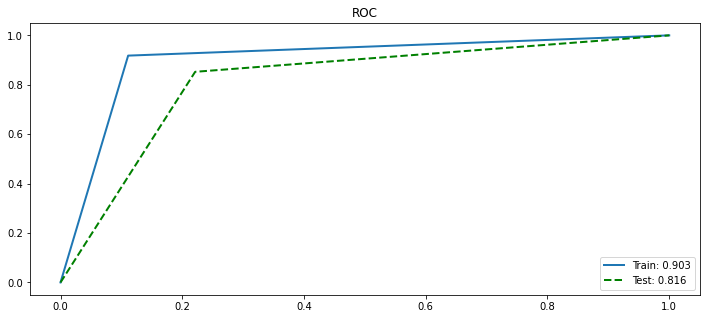

In [8]:
#
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, best_svc.predict(X_train))
test_fpr, test_tpr, test_thresholds    = roc_curve(y_test, y_hat)

plt.figure(figsize=(12, 5))
# plt.grid()

_ = plt.plot(train_fpr, train_tpr, linewidth=2, label=f'Train: {auc(train_fpr, train_tpr):.3f}')
_ = plt.plot(test_fpr, test_tpr, 'g--', linewidth=2, label=f'Test: {auc(test_fpr, test_tpr):.3f}')
_ = plt.title("ROC")

plt.legend()

##### Precision-Recal

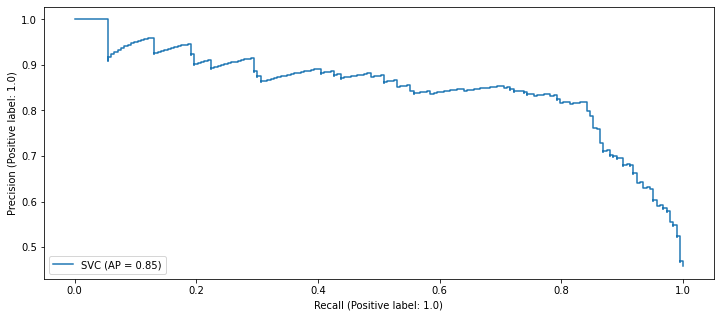

In [9]:
display = PrecisionRecallDisplay.from_estimator(best_svc, X_test, y_test)
display.figure_.set_figwidth(12)
display.figure_.set_figheight(5)

> Outra forma de exibir a curva **precision-recall** é como segue, mas ela tem bem menos pontos
> ```
#
precision, recall, _ = precision_recall_curve(y_test, y_hat)
#
display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()
```

#### Random Forest

- \# Estimators $\rightarrow 10, 20, \dots, 180, 190, 200$
- Profundidade $\rightarrow 4, 6, 8, 10,$ Máxima (`None`)

In [10]:
# Params
parameters = {
    'n_estimators': list(range(10, 201, 10)),
    'max_depth': list(range(4, 11, 2)),
    'criterion':  ['gini', 'entropy', 'log_loss']
}

parameters['max_depth'].append(None)

# Model Search
rfc = GridSearchCV(RFC(), parameters, cv=10, n_jobs=-1, refit=True, verbose=True)

# Fit
timed_fit(rfc, X_train, y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Fitting time: 109.093s ≈ 1.0m


##### Parâmetros

In [11]:
# print(f'Melhor modelo: {rfc.best_estimator_}')
print(f'Melhores parâmetros: {rfc.best_params_}')

Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 130}


##### Métricas

In [12]:
# Test
best_rfc = rfc.best_estimator_
y_hat = best_rfc.predict(X_test)

# Report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87       217
         1.0       0.81      0.91      0.86       183

    accuracy                           0.86       400
   macro avg       0.87      0.87      0.86       400
weighted avg       0.87      0.86      0.87       400



##### ROC

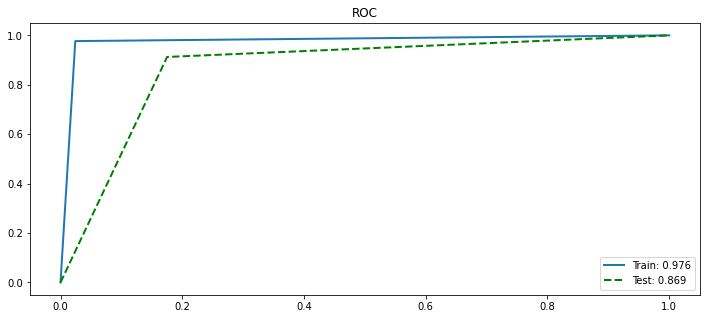

In [13]:
#
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, best_rfc.predict(X_train))
test_fpr, test_tpr, test_thresholds    = roc_curve(y_test, y_hat)

plt.figure(figsize=(12, 5))
# plt.grid()

_ = plt.plot(train_fpr, train_tpr, linewidth=2, label=f'Train: {auc(train_fpr, train_tpr):.3f}')
_ = plt.plot(test_fpr, test_tpr, 'g--', linewidth=2, label=f'Test: {auc(test_fpr, test_tpr):.3f}')
_ = plt.title("ROC")

plt.legend()

##### Precision-Recal

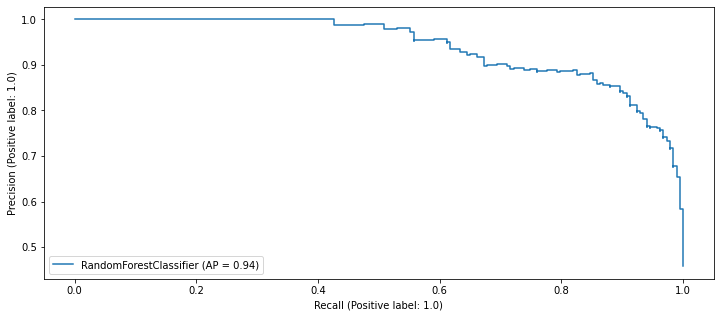

In [14]:
display = PrecisionRecallDisplay.from_estimator(best_rfc, X_test, y_test)
display.figure_.set_figwidth(12)
display.figure_.set_figheight(5)